# Code to generate plots for the paper:
# "It's about time: a thermodynamic information criterion (TIC)"
## By Brendan Lucas, Gemini 2.5 Pro Preview 05-06, Aishani Ghosal, and Jason R. Gree

In [13]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid #solve initial value problem, compute numerical integral
from scipy.linalg import null_space
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

In [14]:
# By Brendan Lucas

#beta = k_B T = 1 
#time is the independent variable.
#the probability vector evolves over time.
#even if the transition rate matrix is not time-dependent, it is coded as a function for a bit of generality
#ensure for dim(p)=N, dim(W)=NxN; dim(dpdt)=N, too, therefore

def two_state_arrhenius_transition_rate_matrix(ε1, ε2, h, β=1, A=1): #for the equilibration regime
    #assuming β=1, A=1 for thermodynamic temperature and prefactor
    #h is the barrier height
    r=A*np.exp(-β*(h-ε1)) #transition rate from grounds to activateds
    ρ=A*np.exp(-β*(h-ε2)) #transition rate from activateds to grounds
    
    W=np.array([[-r, ρ], [r, -ρ]]) #this is the transition rate matrix
    return W
    
def probability_rate_basic_2state_master_equation(time, probability_vector, transition_rate_matrix):
    
    W = transition_rate_matrix
    p = probability_vector
    #print('W: ', W)
    #print('p: ', p)
    dpdt = W @ p
    return dpdt

def solve_basic_2state_master_equation(p_0, transition_rate_matrix, t_b, t_a=0, numtimes=100000):
    time_array = np.linspace(t_a, t_b, numtimes)
    solution = solve_ivp(fun=probability_rate_basic_2state_master_equation, t_span=[t_a, t_b], y0=p_0, t_eval=time_array, args=(transition_rate_matrix,))
    probability_vector_in_time = solution.y
    return time_array, probability_vector_in_time

In [15]:
# By Brendan Lucas
expectation_value = lambda probabilities, function_values: probabilities.dot(function_values)
covariance = lambda probabilities, function_values, gunction_values: expectation_value(probabilities, function_values*gunction_values) - expectation_value(probabilities, function_values)*expectation_value(probabilities, gunction_values)
variance = lambda probabilities, function_values: covariance(probabilities, function_values, gunction_values=function_values)
kullback_leibler_divergence = lambda p, q: expectation_value(p, -np.log(q)) - expectation_value(p, -np.log(p))

In [16]:
# By Brendan Lucas
def compute_2state_TIC(p_init, t_b, A=19.5, β=1, ground_energy=0, activated_energy=-12, barrier_height=0, numtimes=100000, equilibrium_tolerance=1e-15, probability_test=False, to_equilibrium=True):
    #This will generate a pandas table with all the information including TIC and such. TIC will ultimately be a scalar evaluation of the system.
    
    ε1 = ground_energy #this is the reference point; the energy of the grounds on the left of the reaction coordinate
    h = barrier_height #this is the energy to get to the transition state at the center of the reaction coordinate
    ε2 = activated_energy #this is the energy of the activateds on the right of the reaction coordinate
    
    transition_rate_matrix = two_state_arrhenius_transition_rate_matrix(ε1, ε2, h, β, A)

    time_series, probability_series = solve_basic_2state_master_equation(p_0=p_init, t_b=t_b, transition_rate_matrix=transition_rate_matrix, numtimes=numtimes)
    nullspace = null_space(transition_rate_matrix)
    boltzmann_factors = np.squeeze(nullspace)
    partition_function = np.sum(boltzmann_factors)
    equilibrium_distribution = boltzmann_factors/partition_function
    #equilibrium_free_energy = -np.log(partition_function)

    surprisal_series = -np.log(probability_series)
    surprisal_rate_series = np.array([np.gradient(surprisal, time_series) for surprisal in surprisal_series])
    fisher_information_series = np.array([variance(probability, surprisal_rate) for probability, surprisal_rate in zip(probability_series.T, surprisal_rate_series.T)])

    for time_index, instantaneous_probability in enumerate(probability_series.T):
        if kullback_leibler_divergence(instantaneous_probability, equilibrium_distribution)<equilibrium_tolerance:
            time_tilde_eq_index = time_index
            break
    else:
        print('ERROR: Equilibrium was not reached within tolerance=', equilibrium_tolerance)
    delta_t_eq = time_series[time_tilde_eq_index] - time_series[0]
    
    if probability_test:
        #See what the probabilities are doing
        plt.plot(time_series, probability_series.T, label=r'$p(t)$')
        plt.axhline(equilibrium_distribution[0], linestyle='dotted', color='red', label=r'$p_{\text{r, eq}}$')
        plt.axhline(equilibrium_distribution[1], linestyle='dotted', color='green', label=r'$p_{\text{act, eq}}$')
        plt.axvline(delta_t_eq, linestyle='dotted', color='blue', label=r'$\Delta t$')
        plt.legend()
        plt.show()
    
    KLD = kullback_leibler_divergence(p_init, equilibrium_distribution)

    energy_vector = np.array([ground_energy, activated_energy])
    heat_rate_series = np.array([covariance(probability, energy_vector, surprisal_rate) for probability, surprisal_rate in zip(probability_series.T, surprisal_rate_series.T)])
    heat_integral = trapezoid(heat_rate_series, time_series)

    peq0 = float(equilibrium_distribution[0])
    pr0 = float(p_init[0])
    rao_triangle = float(0.5*delta_t_eq**2*fisher_information_series[0])
    TIC = rao_triangle - KLD
    Q = float(heat_integral)
    Q_abs = float(np.abs(Q))
    delta_t = float(delta_t_eq)
    
    return A, β, ε1, ε2, h, peq0, pr0, KLD, rao_triangle, TIC, Q, Q_abs, delta_t

In [17]:
# By Gemini
h_coords = np.linspace(0.05, 0.5, 20)
pr0_coords = np.linspace(0.55, 0.99, 20)

fixed_A = 19.5
fixed_beta = 0.3
fixed_ground_energy = 0
fixed_activated_energy = -12
fixed_t_b = 1000
fixed_numtimes = 1000
fixed_equilibrium_tolerance = 1e-9

In [18]:
# By Gemini
H_mesh, PR0_mesh = np.meshgrid(h_coords, pr0_coords)
TIC_Z_mesh = np.zeros_like(H_mesh)
rao_Z_mesh = np.zeros_like(H_mesh)
KLD_Z_mesh = np.zeros_like(H_mesh)

      
print(f"Starting data generation for a {H_mesh.shape[0]}x{H_mesh.shape[1]} grid...")

# Loop through each parameter combination, call compute_2state_TIC, and store the result
for j, pr0_val in enumerate(pr0_coords):
    current_p_init = np.array([pr0_val, 1.0 - pr0_val])
    for i, h_val in enumerate(h_coords):
        results_tuple = compute_2state_TIC(
            p_init=current_p_init,
            t_b=fixed_t_b,
            A=fixed_A,
            β=fixed_beta,
            ground_energy = fixed_ground_energy,
            activated_energy=fixed_activated_energy,
            barrier_height=h_val, # Current h from the loop
            numtimes=fixed_numtimes,
            equilibrium_tolerance=fixed_equilibrium_tolerance,
            probability_test=False # Set to False to speed up scan; True for single debug runs
        )

        # Store the desire outputs
        KLD_Z_mesh[j, i] = results_tuple[7]
        rao_Z_mesh[j, i] = results_tuple[8]
        TIC_Z_mesh[j, i] = results_tuple[9]

        # Print progress
        if (j+1) % 5 == 0 or (j+1) == len(pr0_coords):
            print(f"Completed row {j+1}/{len(pr0_coords)} (pr0 = {pr0_val:.2f})")
print("Data Generation Complete")

Starting data generation for a 20x20 grid...
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 5/20 (pr0 = 0.64)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/20 (pr0 = 0.76)
Completed row 10/2

In [19]:
# By Gemini
# --- Find Extrema Coordinates and Values ---

# KLD Extrema
idx_min_kld_flat = np.argmin(KLD_Z_mesh)
idx_max_kld_flat = np.argmax(KLD_Z_mesh)
min_kld_row, min_kld_col = np.unravel_index(idx_min_kld_flat, KLD_Z_mesh.shape)
max_kld_row, max_kld_col = np.unravel_index(idx_max_kld_flat, KLD_Z_mesh.shape)

h_min_kld = H_mesh[min_kld_row, min_kld_col]
pr0_min_kld = PR0_mesh[min_kld_row, min_kld_col]
val_min_kld = KLD_Z_mesh[min_kld_row, min_kld_col]

h_max_kld = H_mesh[max_kld_row, max_kld_col]
pr0_max_kld = PR0_mesh[max_kld_row, max_kld_col]
val_max_kld = KLD_Z_mesh[max_kld_row, max_kld_col]

# Rao Term (K) Extrema
idx_min_rao_flat = np.argmin(rao_Z_mesh)
idx_max_rao_flat = np.argmax(rao_Z_mesh)
min_rao_row, min_rao_col = np.unravel_index(idx_min_rao_flat, rao_Z_mesh.shape)
max_rao_row, max_rao_col = np.unravel_index(idx_max_rao_flat, rao_Z_mesh.shape)

h_min_rao = H_mesh[min_rao_row, min_rao_col]
pr0_min_rao = PR0_mesh[min_rao_row, min_rao_col]
val_min_rao = rao_Z_mesh[min_rao_row, min_rao_col]

h_max_rao = H_mesh[max_rao_row, max_rao_col]
pr0_max_rao = PR0_mesh[max_rao_row, max_rao_col]
val_max_rao = rao_Z_mesh[max_rao_row, max_rao_col]

# TIC Extrema
idx_min_tic_flat = np.argmin(TIC_Z_mesh)
idx_max_tic_flat = np.argmax(TIC_Z_mesh)
min_tic_row, min_tic_col = np.unravel_index(idx_min_tic_flat, TIC_Z_mesh.shape)
max_tic_row, max_tic_col = np.unravel_index(idx_max_tic_flat, TIC_Z_mesh.shape)

h_min_tic = H_mesh[min_tic_row, min_tic_col]
pr0_min_tic = PR0_mesh[min_tic_row, min_tic_col]
val_min_tic = TIC_Z_mesh[min_tic_row, min_tic_col]

h_max_tic = H_mesh[max_tic_row, max_tic_col]
pr0_max_tic = PR0_mesh[max_tic_row, max_tic_col]
val_max_tic = TIC_Z_mesh[max_tic_row, max_tic_col]

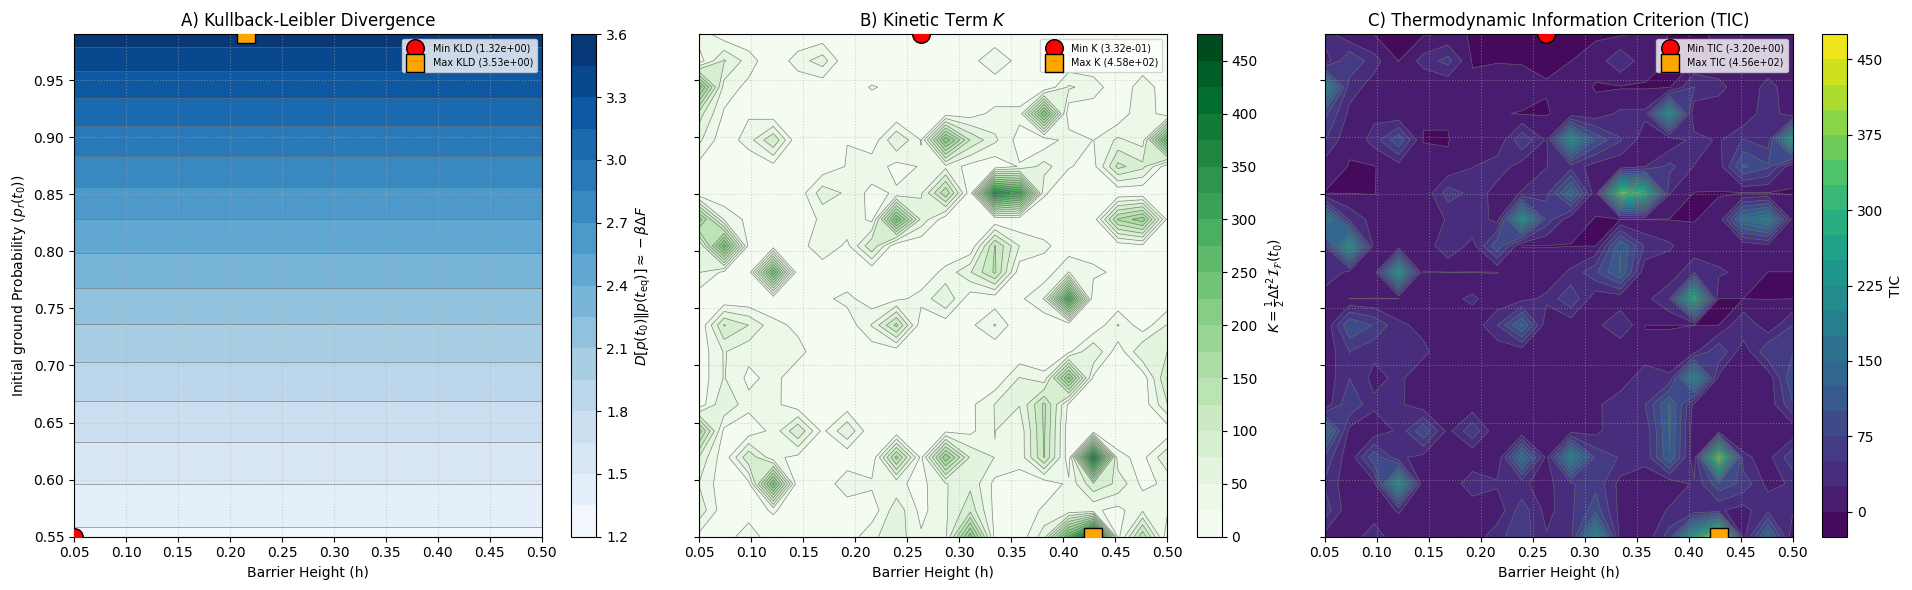

In [20]:
# By Gemini
# --- Plotting (3 Subplots with Min/Max Points) ---
import matplotlib.pyplot as plt # Ensure it's imported

# H_mesh, PR0_mesh are from Cell B
# KLD_Z_mesh, rao_Z_mesh, TIC_Z_mesh are your populated 2D result arrays

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6)) # Adjusted figsize for legibility
# Consider a slightly larger figsize if legends and titles are cramped.

# Common scatter plot properties
marker_size = 160
edge_color = 'black'
min_marker = 'o' # Circle for minimum
max_marker = 's' # Square for maximum
z_order_points = 5 # Ensure points are on top

# --- Plot 1: KLD ---
ax0 = axes[0]
contour_kld = ax0.contourf(H_mesh, PR0_mesh, KLD_Z_mesh, levels=20, cmap='Blues')
fig.colorbar(contour_kld, ax=ax0, label=r'$D[p(t_0)\|p(t_{\text{eq}})]\approx -\beta\Delta F$')
ax0.contour(H_mesh, PR0_mesh, KLD_Z_mesh, levels=contour_kld.levels, colors='dimgray', linewidths=0.5, alpha=0.8) # Darker gray for lines
ax0.set_xlabel('Barrier Height (h)')
ax0.set_ylabel('Initial ground Probability ($p_r(t_0)$)') # LaTeX for subscript
ax0.set_title(r'A) Kullback-Leibler Divergence') # Simpler title
ax0.grid(True, linestyle=':', alpha=0.5)

# Add KLD min/max points
ax0.scatter(h_min_kld, pr0_min_kld, color='red', edgecolor=edge_color, marker=min_marker, s=marker_size, 
            label=f'Min KLD ({val_min_kld:.2e})', zorder=z_order_points)
ax0.scatter(h_max_kld, pr0_max_kld, color='orange', edgecolor=edge_color, marker=max_marker, s=marker_size, 
            label=f'Max KLD ({val_max_kld:.2e})', zorder=z_order_points)
ax0.legend(loc='best', fontsize='x-small') # 'best' tries to find a good spot, 'x-small' for font

# --- Plot 2: Rao Term (K) ---
ax1 = axes[1]
contour_rao = ax1.contourf(H_mesh, PR0_mesh, rao_Z_mesh, levels=20, cmap='Greens')
fig.colorbar(contour_rao, ax=ax1, label=r'$K = \frac{1}{2}\Delta t^2 \mathcal{I}_{\mathcal{F}}(t_0)$')
ax1.contour(H_mesh, PR0_mesh, rao_Z_mesh, levels=contour_rao.levels, colors='dimgray', linewidths=0.5, alpha=0.8)
ax1.set_xlabel('Barrier Height (h)')
ax1.tick_params(axis='y', labelleft=False)
ax1.set_title(r'B) Kinetic Term $K$') # Simpler title
ax1.grid(True, linestyle=':', alpha=0.5)

# Add K min/max points
ax1.scatter(h_min_rao, pr0_min_rao, color='red', edgecolor=edge_color, marker=min_marker, s=marker_size, 
            label=f'Min K ({val_min_rao:.2e})', zorder=z_order_points)
ax1.scatter(h_max_rao, pr0_max_rao, color='orange', edgecolor=edge_color, marker=max_marker, s=marker_size, 
            label=f'Max K ({val_max_rao:.2e})', zorder=z_order_points)
ax1.legend(loc='best', fontsize='x-small')

# --- Plot 3: TIC ---
ax2 = axes[2]
contour_tic = ax2.contourf(H_mesh, PR0_mesh, TIC_Z_mesh, levels=20, cmap='viridis') # 'RdYlBu' is good for diverging data
fig.colorbar(contour_tic, ax=ax2, label='TIC')
ax2.contour(H_mesh, PR0_mesh, TIC_Z_mesh, levels=contour_tic.levels, colors='dimgray', linewidths=0.5, alpha=0.8)
ax2.set_xlabel('Barrier Height (h)')
ax2.tick_params(axis='y', labelleft=False)
ax2.set_title('C) Thermodynamic Information Criterion (TIC)')
ax2.grid(True, linestyle=':', alpha=0.5)

# Add TIC min/max points
ax2.scatter(h_min_tic, pr0_min_tic, color='red', edgecolor=edge_color, marker=min_marker, s=marker_size, 
            label=f'Min TIC ({val_min_tic:.2e})', zorder=z_order_points)
ax2.scatter(h_max_tic, pr0_max_tic, color='orange', edgecolor=edge_color, marker=max_marker, s=marker_size, 
            label=f'Max TIC ({val_max_tic:.2e})', zorder=z_order_points)
ax2.legend(loc='best', fontsize='x-small')


plt.tight_layout(rect=[0, 0, 0.97, 1]) # rect can give more space for colorbars/figure titles
plt.show()